In [1]:
# make external scripts auto reload
%load_ext autoreload
%autoreload 2

In [350]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from candidate_generation import *

In [3]:
BASE_PATH = '../../../data/parquet/'

transactions_original = pd.read_parquet(BASE_PATH + 'transactions_train.parquet')
customers_original = pd.read_parquet(BASE_PATH + 'customers.parquet')
articles_original = pd.read_parquet(BASE_PATH + 'articles.parquet')

transactions = transactions_original.copy()
customers = customers_original.copy()
articles = articles_original.copy()

In [305]:
def recall(predictions, test_data):
    joined = pd.merge(test_data, predictions, how='inner').drop_duplicates()
    relevant_selected = joined.groupby('customer_id').count()
    relevant_total = test_data.groupby('customer_id').count()

    recall = relevant_selected.divide(relevant_total, fill_value=0)
    return recall.mean().values[0]
    # return recall[~recall.article_id.isna()].mean().values[0]
    # return recall.loc[test_data.customer_id.unique()].mean().values[0]
    # return recall.loc[predictions.customer_id.unique()].mean().values[0]

def print_scheme(v, name):
    cpu = len(v) / len(v.customer_id.unique())
    r = recall(v, test_data)
    print(f'{name:>40}: {cpu:>8.2f} {r:>8.2%}')

def metrics(v):
    cpu = len(v) / len(v.customer_id.unique())
    r = recall(v, test_data)
    return cpu, r

In [266]:
# clean slate
transactions = transactions_original.copy()
customers = customers_original.copy()
articles = articles_original.copy()

# split data into test en training
test_week = 104
num_train_weeks = 10
train_weeks = np.arange(test_week - num_train_weeks, test_week)
test_data = transactions[transactions.week == test_week][['customer_id', 'article_id']].drop_duplicates()
test_X = pd.Series(test_data['customer_id'].unique(), name='customer_id')
train_data = transactions[transactions.week.isin(train_weeks)].copy()
train_data = add_relative_week(train_data, test_week)

# add bin/clip features
transactions['clipped_price'] = transactions['price'].clip(0, 150)
transactions['binned_price'] = pd.cut(transactions.price, bins=[0, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 20, 25, 30, 40, 60, np.inf])
customers['age_group'] = pd.cut(customers.age, bins=[0, 40, 60, 100], labels=["Young Adult", "Middle Aged", "Old"])

# add purchase behaviour features
article_max_price = transactions.groupby('article_id')['binned_price'].max().to_frame('article_price')
articles = pd.merge(articles, article_max_price, on='article_id', how='left')

bask = baskets(train_data, test_week, test_X, True)

In [174]:
v = len(test_X) / len(customers)
print(f'test customers: {len(test_X)} ({v:.2%} of total)')
v = len(set(test_X) & set(train_data.customer_id.unique())) / len(test_X)
print(f'test customers in training data: {v:.2%}')
v = len(pd.merge(train_data, test_data, on=['customer_id', 'article_id'])) / len(test_data)
print(f'repurchase rate: {v:.2%}')

test customers: 68984 (5.03% of total)
test customers in training data: 66.56%
repurchase rate: 3.44%


In [534]:
c = candidates_article_feature(bask, train_data, articles, 'product_code', 10, 20, 1, 3, False, True)
print_scheme(c, 'test')

                                    test:    18.26    5.71%


In [536]:
c = candidates_article_feature(bask, train_data, articles, 'product_code', 10, 20, 10, 3, False, True)
print_scheme(c, 'test')

                                    test:    21.33    5.74%


In [468]:
c = candidates_popularity(bask, train_data, 10, 10)
print_scheme(c, 'popularity')

c = candidates_repurchase(bask, train_data, 10, False)
print_scheme(c, 'repurchase')

for f in ['FN', 'age', 'age_group', 'postal_code']:
    c = candidates_customer_feature(bask, train_data, customers, f, 10, 10, False)
    print_scheme(c, f)

for f in ['product_code', 
          'prod_name',
          'product_type_name', 
          'product_group_name',
          'graphical_appearance_name',
          'colour_group_name',
          'perceived_colour_value_name',
          'perceived_colour_master_name',
          'department_name',
          'index_name',
          'index_group_name',
          'section_name',
          'garment_group_name',
          'article_price']:
    c = candidates_article_feature(bask, train_data, articles, f, 10, 20, 10, 10, False, False)
    print_scheme(c, f)

                              popularity:    10.00    1.21%
                              repurchase:     8.55    3.69%
                                      FN:    10.00    1.29%
                                     age:    10.00    1.54%
                               age_group:    10.00    1.57%
                             postal_code:     8.13    2.59%
                            product_code:    22.74    5.82%
                               prod_name:    21.83    5.64%
                       product_type_name:    35.10    2.86%
                      product_group_name:    23.45    1.66%
               graphical_appearance_name:    23.34    1.54%
                       colour_group_name:    35.60    2.27%
             perceived_colour_value_name:    24.92    2.04%
            perceived_colour_master_name:    31.83    2.02%
                         department_name:    37.02    3.19%
                              index_name:    20.55    1.62%
                        index_group_name

In [467]:
c = candidates_popularity(bask, train_data, 10, 1)
print_scheme(c, 'popularity')

c = candidates_repurchase(bask, train_data, 2, True)
print_scheme(c, 'repurchase')

for f in ['FN', 'age', 'age_group', 'postal_code']:
    c = candidates_customer_feature(bask, train_data, customers, f, 10, 1, False)
    print_scheme(c, f)

for f in ['product_code', 
          'prod_name',
          'product_type_name', 
          'product_group_name',
          'graphical_appearance_name',
          'colour_group_name',
          'perceived_colour_value_name',
          'perceived_colour_master_name',
          'department_name',
          'index_name',
          'index_group_name',
          'section_name',
          'garment_group_name',
          'article_price']:
    c = candidates_article_feature(bask, train_data, articles, f, 10, 20, 1, 3, False, True)
    print_scheme(c, f)


                              popularity:    10.00    2.22%
                              repurchase:     5.41    3.49%
                                      FN:    10.00    2.30%
                                     age:    10.00    2.27%
                               age_group:    10.00    2.35%
                             postal_code:     4.49    2.28%
                            product_code:    18.26    5.71%
                               prod_name:    17.39    5.54%
                       product_type_name:    33.06    3.66%
                      product_group_name:    22.72    2.54%
               graphical_appearance_name:    22.49    2.61%
                       colour_group_name:    33.68    3.23%
             perceived_colour_value_name:    24.36    2.90%
            perceived_colour_master_name:    30.51    3.15%
                         department_name:    34.57    4.34%
                              index_name:    20.02    2.58%
                        index_group_name

In [524]:
candidates = [
    candidates_popularity(bask, train_data, 40, 1),
    candidates_repurchase(bask, train_data, 2, True),
    candidates_article_feature(bask, train_data, articles, "product_code", 10, 20, 2, 3, False, True),
    candidates_article_feature(bask, train_data, articles, "department_name", 5, 20, 3, 3, False, True),
    candidates_customer_feature(bask, train_data, customers, "age", 10, 3, False),
    candidates_customer_feature(bask, train_data, customers, "postal_code", 10, 3, False),
    # candidates_popularity(bask, train_data, 82, 1),
    # candidates_repurchase(bask, train_data, 10, True),
]

c = pd.concat(candidates).drop_duplicates(["customer_id", "article_id"])
print_scheme(c, 'combined')

                                combined:    87.46   13.29%


In [ ]:
# prod_name(10, 20)
3A
    1R: (12.17399228961836, 0.04642823541078528)
    2R: (16.98410331817301, 0.053580433215231635)
    3R: (18.92794645340434, 0.0558762985765818)
    1A: (11.585803746233633, 0.029916496846391416)
    2A: (12.834153701366118, 0.03911432187644066)
    3A: (13.959600720630132, 0.044774947749628397)
    5A: (15.73439043145201, 0.05037126265466007)
    10A: (20.14412533113262, 0.05652159550021316)

In [ ]:
# popularity(10)
1: (10.0, 0.022213186580556512)
2: (10.0, 0.021671907240515403)
3: (10.0, 0.02013242016597525)
10: (10.0, 0.012099027037421457)

In [ ]:
# repurchase
1R: (3.308149664604931, 0.031062855367461843)
2R: (5.41349420681244, 0.034884776908921625)
1A: (3.5173638516179953, 0.022190793767712633)
2A: (4.067604399883189, 0.02810954517317401)
3A: (4.611646856544816, 0.031037497343618183)
10A: (8.546759299590557, 0.03694707271151196)

In [ ]:
(80.44511024228217, 0.11668299262933378)
(81.16456547500627, 0.10880975305044174)

Text(0.5, 1.0, 'Recall/Count')

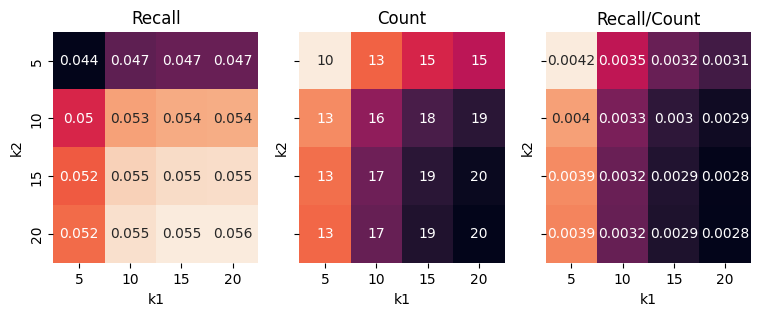

In [381]:
# calculate results
results = []
for k1 in [5, 10, 15, 20]:
    for k2 in [5, 10, 15, 20]:
        c = candidates_article_feature(bask, train_data, articles, "product_code", k1, k2, 2, 2, False, True)
        cpu, rec = metrics(c)
        results.append((k1, k2, cpu, rec))

results = pd.DataFrame(results, columns=['k1', 'k2', 'cpu', 'recall'])
results['tradeoff'] = results.recall / results.cpu

Text(0.5, 1.0, 'Recall/Count')

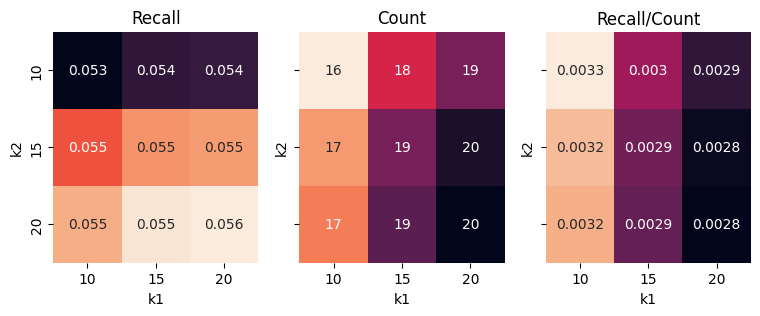

In [656]:
# plot results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(9, 3))
resss = results[(results.k1 > 5) & (results.k2 > 5)]
sns.heatmap(resss.pivot(columns='k1', index='k2', values='recall'), annot=True, ax=ax1, cbar=False)
sns.heatmap(resss.pivot(columns='k1', index='k2', values='cpu'), cmap='rocket_r', annot=True, ax=ax2, cbar=False)
sns.heatmap(resss.pivot(columns='k1', index='k2', values='tradeoff'), annot=True, ax=ax3, cbar=False)
ax1.set_title('Recall')
ax2.set_title('Count')
ax3.set_title('Recall/Count')

In [394]:
results_all = []
for d1 in [1, 2, 3, 5, 10]:
    for d2 in [1, 2, 3, 5, 10]:
        for r1 in [True, False]:
            for r2 in [True, False]:
                c = candidates_article_feature(bask, train_data, articles, "product_code", 5, 20, d1, d2, r1, r2)
                cpu, rec = metrics(c)
                results_all.append((d1, d2, r1, r2, cpu, rec))

results_all = pd.DataFrame(results_all, columns=['d1', 'd2', 'r1', 'r2', 'cpu', 'recall'])
results_all['tradeoff'] = results_all.recall / results_all.cpu

Text(50.722222222222214, 0.5, 'd2')

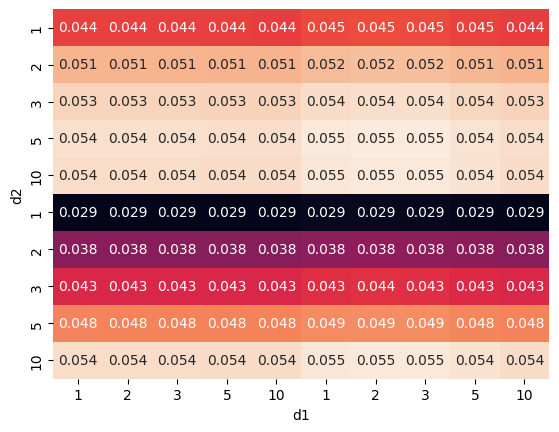

In [531]:
v = 'recall'
a = results_all[results_all.r1 & results_all.r2].pivot(columns='d1', index='d2', values=v)
b = results_all[~results_all.r1 & results_all.r2].pivot(columns='d1', index='d2', values=v)
c = results_all[results_all.r1 & ~results_all.r2].pivot(columns='d1', index='d2', values=v)
d = results_all[~results_all.r1 & ~results_all.r2].pivot(columns='d1', index='d2', values=v)

ax = sns.heatmap(np.block([
    [a.to_numpy(), b.to_numpy()],
    [c.to_numpy(), d.to_numpy()]
]), annot=True, cbar=False)
ax.set_xticklabels([1, 2, 3, 5, 10, 1, 2, 3, 5, 10])
ax.set_yticklabels([1, 2, 3, 5, 10, 1, 2, 3, 5, 10])
ax.set_xlabel('d1')
ax.set_ylabel('d2')

<Axes: xlabel='k', ylabel='recall'>

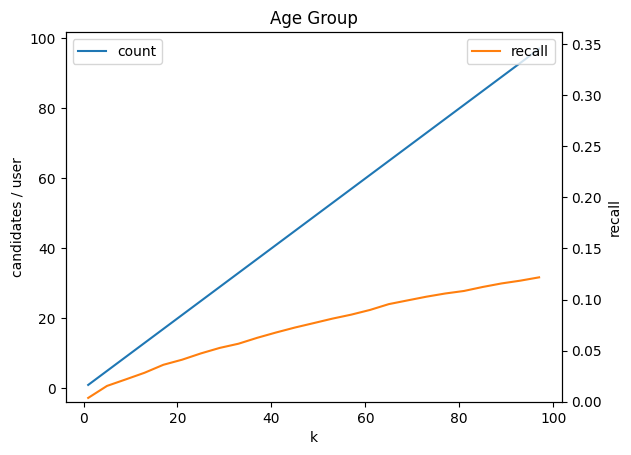

In [616]:
res_age = []
for k in np.arange(1, 100, 4):
    c = candidates_customer_feature(bask, train_data, customers, 'age_group', k, 1, False)
    cpu, rec = metrics(c)
    res_age.append((k, cpu, rec))
res_age = pd.DataFrame(res_age, columns=['k', 'count', 'recall'])
ax1 = res_age[['k', 'count']].plot(x='k', xlabel='k', ylabel='candidates / user', title='Age Group')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
recall1 = res_age[res_age['k']==1]['recall'].values[0]
res_age[['k', 'recall']].plot(x='k', ax=ax2, c='tab:orange', ylabel='recall', ylim=(0, 97*recall1))

In [652]:
res_pop = []
for d in np.arange(0, 10):
    c1 = candidates_popularity(bask, train_data, 10, d + 1)
    c2 = candidates_customer_feature(bask, train_data, customers, 'age', 10, d + 1, False)
    c3 = candidates_article_feature(bask, train_data, articles, "index_name", 10, 10, d + 1, 3, False, True)
    _, rec1 = metrics(c1)
    _, rec2 = metrics(c2)
    _, rec3 = metrics(c3)
    res_pop.append((d+1, rec1, rec2, rec3))
res_pop = pd.DataFrame(res_pop, columns=['d', 'popularity', 'age', 'index_name'])

<Axes: title={'center': 'Recall by # of weeks considered'}, xlabel='d', ylabel='recall'>

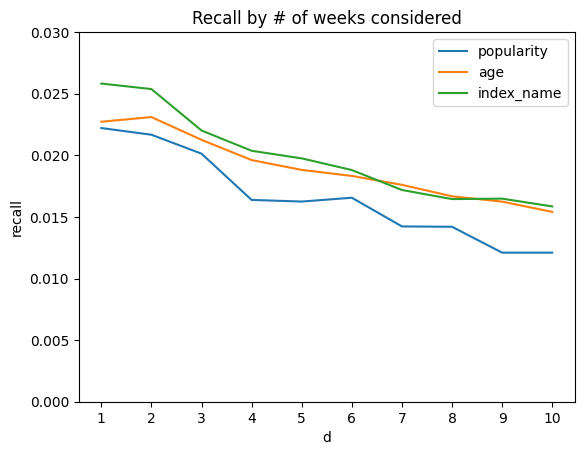

In [654]:
res_pop.plot(y=['popularity', 'age', 'index_name'], x='d', xlabel='d', ylabel='recall', ylim=(0, 0.03), title='Recall by # of weeks considered', xticks=res_pop.d)

In [456]:
# radek
def baseline(data, test_week):
    ### repurchase
    # each week is seen as a basket
    # the items bought in one basket, will be example for the next basket
    # the items bought in the last basket, will be candidates for the test basket
    c2weeks = data.groupby('customer_id')['week'].unique()
    c2weeks2shifted_weeks = {}
    for c_id, weeks in c2weeks.items():
        c2weeks2shifted_weeks[c_id] = {}
        for i in range(weeks.shape[0]-1):
            c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
        c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    candidates_last_purchase = data.copy()
    weeks = []
    for i, (c_id, week) in enumerate(zip(data['customer_id'], data['week'])):
        weeks.append(c2weeks2shifted_weeks[c_id][week])
    candidates_last_purchase.week=weeks

    ### bestseller
    # if a user bought an item in a given week, the 12 most popular items in the previous week are example for that week
    # the best selling items in the last week are candidates for all users
    mean_price = data \
        .groupby(['week', 'article_id'])['price'].mean()
    sales = data \
        .groupby('week')['article_id'].value_counts() \
        .groupby('week').rank(method='dense', ascending=False) \
        .groupby('week').head(12).rename('bestseller_rank').astype('int8')
    bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
    bestsellers_previous_week.week += 1
    unique_transactions = data \
        .groupby(['week', 'customer_id']) \
        .head(1) \
        .drop(columns=['article_id', 'price']) \
        .copy()
    candidates_bestsellers = pd.merge(
        unique_transactions,
        bestsellers_previous_week,
        on='week',
    )
    test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
    test_set_transactions.week = test_week
    candidates_bestsellers_test_week = pd.merge(
        test_set_transactions,
        bestsellers_previous_week,
        on='week'
    )
    candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
    candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

    ### combine
    d = data.copy()
    d['purchased'] = True
    
    result = pd.concat([
        d, candidates_last_purchase, candidates_bestsellers
    ])
    result.purchased.fillna(False, inplace=True)
    result.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

    result = pd.merge(
        result,
        bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
        on=['week', 'article_id'],
        how='left'
    )
    result = result[result.week != result.week.min()]
    result.bestseller_rank.fillna(999, inplace=True)

    result.sort_values(['week', 'customer_id'], inplace=True)
    result.reset_index(drop=True, inplace=True)

    return result
    
candidates_radek = baseline(train_data, test_week)
print_scheme(candidates_radek[candidates_radek.week == test_week], 'radek')

                                   radek:    15.15    4.70%


In [18]:
print_scheme(merge_candidates([
    repurchase(train_data, test_X)
]))
print_scheme(merge_candidates([
    repurchase(train_data, test_X),
    popular_similar_items(train_data, test_X, articles, 'prod_name', 10, 3)
]))
print_scheme(merge_candidates([
    repurchase(train_data, test_X),
    popular_similar_items(train_data, test_X, articles, 'prod_name', 10, 3),
    popular_by_feature(train_data, test_X, customers, 'postal_code', 10),
    popular_by_feature(train_data, test_X, customers, 'age', 10),
]))
print_scheme(merge_candidates([
    repurchase(train_data, test_X),
    popular_similar_items(train_data, test_X, articles, 'prod_name', 20, 6, 2),
    popular_by_feature(train_data, test_X, customers, 'postal_code', 15),
    popular_by_feature(train_data, test_X, customers, 'age', 15),
]))

10.13	2.63%
14.00	3.04%
24.74	4.23%
33.34	4.71%
